In [1]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

In [12]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%load_ext line_profiler
%load_ext memory_profiler

## Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018])

In [7]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']
all_years = range(2005, 2019)

In [8]:
# Create train and test score tables for male skaters
season_train, world_train, season_test, world_test = train_test_split(male_scores, train_years, test_years)
season_train.shape, world_train.shape, season_test.shape, world_test.shape

((1216, 4), (238, 4), (507, 4), (96, 4))

In [9]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)

# Combine latent scores using logistic regression

In [10]:
# Select relevant rows from male season scores in 2017 for toy example
sample_season_scores = season_scores.loc[[1758, 1760, 1765, 1769, 1771, 1776, 1787]]

# Transform long score table to pivot form
season_pivot = pd.pivot_table(sample_season_scores[['name', 'event', 'score']], values='score', index='name', columns='event')
# Store skater and event names to retrieve later
skater_names = list(season_pivot.index) # ['Alexander, MAJOROV', 'Javier, FERNANDEZ', 'Misha, GE', 'Takahito, MURA']
event_names = list(season_pivot.columns) # ['CA', 'FR', 'RU']

# Convert pivot table to numpy array
true_scores = season_pivot.values 

In [13]:
baseline, event_scores, skater_scores, rmse = batch_gd_multi(sample_season_scores, init_seed=42,
alpha=0.0005, n_iter=1000, n_factors=2, return_rmse=True)

Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -4.13612e-05


In [14]:
world_ranking = ['Javier, FERNANDEZ', 'Takahito, MURA', 'Misha, GE', 'Alexander, MAJOROV']
skater_scores = skater_scores.reindex(world_ranking)

In [15]:
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
y = np.ones(len(X))
X

array([[ 0.77421447,  0.7929066 ],
       [ 1.62399575, -1.35273364],
       [ 2.29622991,  0.74138494],
       [ 0.84978128, -2.14564025],
       [ 1.52201543, -0.05152167],
       [ 0.67223415,  2.09411858]])

In [16]:
beta = np.full(X.shape[1], 0.5)
alpha = 0.001
n_iter = 1000
for i in range(n_iter):
    prob = 1 / (1 + np.exp(-X @ beta))
    gradient = (y - prob) @ X
    beta = beta + alpha * gradient
    
    if i in [n_iter-2, n_iter-1]:
        log_likelihood = y @ np.log(prob)
        print(f'i: {i}, avg ll: {log_likelihood/len(X)}')
    
beta

i: 998, avg ll: -0.13810343619496832
i: 999, avg ll: -0.13801945599432072


array([1.75780504, 0.14015987])

In [17]:
y_pred = (X @ beta) > 0
y_pred

array([ True,  True,  True,  True,  True,  True])

In [18]:
n_skaters = len(world_ranking)
counter = [0] * n_skaters
ordered_indices = combinations(range(n_skaters), 2)
for y, (i, j) in zip(y_pred, ordered_indices):
    if y == True:
        counter[i] += 1
    else:
        counter[j] += 1
        
predicted_ranking = [skater for rank, skater in sorted(zip(counter, world_ranking), reverse=True)]
predicted_ranking

['Javier, FERNANDEZ', 'Takahito, MURA', 'Misha, GE', 'Alexander, MAJOROV']

In [19]:
def convert_to_ranking(y_pred, world_ranking):
    n_skaters = len(world_ranking)
    counter = [0] * n_skaters
    ordered_indices = combinations(range(n_skaters), 2)
    for y, (i, j) in zip(y_pred, ordered_indices):
        if y == True:
            counter[i] += 1
        else:
            counter[j] += 1
            
    predicted_ranking = [skater for rank, skater in sorted(zip(counter, world_ranking), reverse=True)]
    
    return predicted_ranking

In [20]:
convert_to_ranking(y_pred, world_ranking)

['Javier, FERNANDEZ', 'Takahito, MURA', 'Misha, GE', 'Alexander, MAJOROV']

Try for 2017 male skaters

In [159]:
def log_gradient_ascent(X, alpha=0.001, n_iter=1000, seed=42, log_ll=False, log_every=10, additional_iter=[]):
    random_state = np.random.RandomState(seed=seed)
    beta = random_state.random_sample(X.shape[1])
    beta = np.full(X.shape[1], 0.5)
    y = np.ones(X.shape[0])
    ll_log = []
    
    for i in range(n_iter):
        prob = 1 / (1 + np.exp(-X @ beta))
        gradient = (y - prob) @ X
        beta = beta + alpha * gradient
        
        if log_ll and (i%log_every==0 or (i in additional_iter)):
            ll_avg = y @ np.log(prob) / len(y)
            yield i, beta, ll_avg
        
        if i in [n_iter-2, n_iter-1]:
            log_likelihood = y @ np.log(prob)
            print(f'i: {i}, avg ll: {log_likelihood/len(X)}')
            
    return beta

In [22]:
season_scores, world_scores = get_yearly_scores(2017, season_train, world_train)
baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores,
alpha=0.0005, n_iter=1000, n_factors=50, return_rmse=True)

Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -8.7e-09


In [23]:
skater_scores = skater_scores.reindex(world_scores.index)
normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)

In [24]:
X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
print(X.shape)
X

(276, 50)


array([[ 1.31687959, -0.2671448 , -0.53267894, ..., -2.41102939,
        -0.26444986,  1.00658698],
       [ 2.9417398 , -0.27174558, -0.57801748, ..., -0.59997308,
         0.05086234,  2.91090971],
       [ 2.64362098,  0.55935797, -0.71593188, ..., -2.4838736 ,
        -1.0189137 ,  2.93697039],
       ...,
       [ 1.21612145,  1.69646041,  0.6230803 , ..., -0.86580232,
         0.43981237, -1.25332251],
       [-0.13534635,  0.34437302, -0.47178943, ..., -0.31750738,
         0.9221538 ,  0.20645316],
       [-1.3514678 , -1.35208739, -1.09486974, ...,  0.54829494,
         0.48234143,  1.45977567]])

In [25]:
beta = log_gradient_ascent(X, n_iter=10)
print(((X @ beta) > 0).sum())

i: 8, avg ll: -0.43778034660348003
i: 9, avg ll: -0.417160939049043
242


In [26]:
y_pred = (X @ beta) > 0
y_pred.sum()

242

In [27]:
avg_scores = season_scores.groupby('name')['score'].mean()
_, world_ranking = return_ranking(avg_scores, world_scores)

In [28]:
predicted_ranking = convert_to_ranking(y_pred, world_ranking)
calculate_kendall_tau(predicted_ranking, world_ranking)

There are 242 concordant_pairs out of 276 pairs


0.7536231884057971

Visualization

In [168]:
predicted_rankings = []
taus = []
lls = []
iter_log = []

for i, beta, ll in log_gradient_ascent(X, n_iter=301, log_ll=True):
    y_pred = (X @ beta) > 0
    predicted_ranking = convert_to_ranking(y_pred, world_ranking)
    tau = calculate_kendall_tau(predicted_ranking, world_ranking, verbose=False)
    iter_log.append(i)
    lls.append(ll)
    predicted_rankings.append(predicted_ranking)
    taus.append(tau)

i: 299, avg ll: -0.04902599414033616
i: 300, avg ll: -0.048953377651495725


In [169]:
def update(i, fig, ax1, ax2, ax3, verbose=False):
    if verbose:
        print(i, end=' ')
    fig.suptitle(f'Iteration {iter_log[i]}\nα = 0.0005', x=0.5, y=0.85, va='bottom', ha='center', fontsize=20)
    
    if i == 0:
        ax1.plot(iter_log[i], lls[i], '.', color='tab:brown', clip_on=False)
        ax2.plot(iter_log[i], taus[i], '.', color='tab:orange', clip_on=False)
    if i >= 1:
        ax1.plot(iter_log[i-1:i+1], lls[i-1:i+1], '.-', color='tab:brown', clip_on=False)
        ax2.plot(iter_log[i-1:i+1], taus[i-1:i+1], '.-', color='tab:orange', clip_on=False)
        
    ax3.lines = []
    ax3.texts = []
    plot_multiple_rankings(fig, ax3, [predicted_rankings[i], world_ranking], ['Predicted', 'World'], xfontsize=15)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 0 

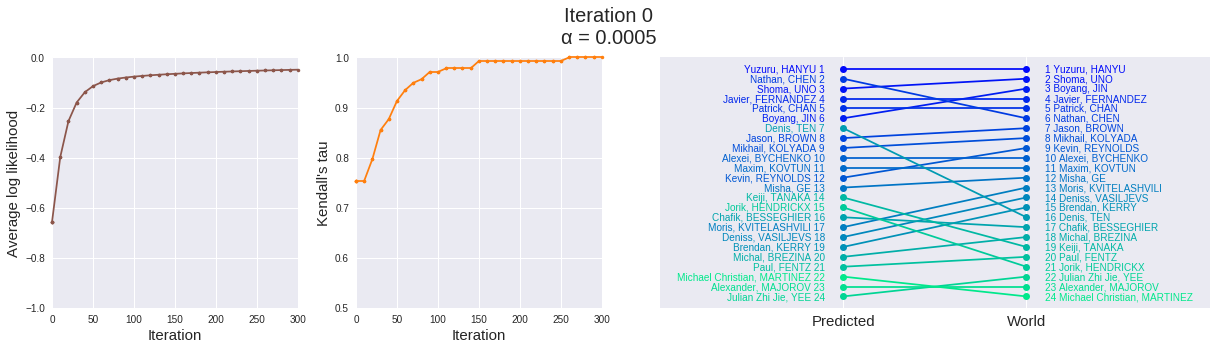

In [171]:
# Set up figure grid
fig = plt.figure(figsize=(17, 5))
grid = plt.GridSpec(6, 4)

ax1 = fig.add_subplot(grid[1:, 0])
ax1.set_xlim(0, iter_log[-1])
ax1.set_ylim(-1, 0)
ax1.set_yticks(np.arange(-1, 0.01, 0.2))
ax1.set_xlabel('Iteration', fontsize=15)
ax1.set_ylabel('Average log likelihood', fontsize=15)

ax2 = fig.add_subplot(grid[1:, 1])
ax2.set_xlim(0, iter_log[-1])
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Iteration', fontsize=15)
ax2.set_ylabel("Kendall's tau", fontsize=15)

ax3 = fig.add_subplot(grid[1:, 2:])

anim = FuncAnimation(fig, lambda i: update(i, fig, ax1, ax2, ax3, verbose=True), 
                     frames=len(iter_log), interval=500)

anim.save('viz/log_anim.gif', writer='imagemagick')

## Cross validation

In [1252]:
def get_tau_from_X_beta(X, beta):
    n_concordant_pairs = (X @ beta > 0).sum()
    n_pairs = len(X)
    return (2 * n_concordant_pairs - n_pairs) / n_pairs

In [1253]:
random_state = np.random.RandomState(seed=42)
years1 = list(random_state.choice(train_years, size=5, replace=False))
years2 = [year for year in train_years if year not in fold1_years]

In [1254]:
avg = AverageScore()
avg_result = avg.evaluate_over_years(all_years, all_season_scores, all_world_scores).set_index('year')
avg_taus = avg_result['tau'].to_dict()

In [1329]:
n_factors = 24
X1 = {}
X2 = {}

for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, season_train, world_train)
    baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores,
    alpha=0.0005, n_iter=1000, n_factors=n_factors, return_rmse=True)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X

2005
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -8.477e-07
2006
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.067e-07
2007
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.3185e-06
2009
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -4.556e-07
2010
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.506e-07
2012
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.71335e-05
2013
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -6.67e-08
2014
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -6.8911e-06
2016
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.419e-07
2017
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.428e-07


In [1330]:
beta1 = log_gradient_ascent(np.concatenate(list(X1.values())), n_iter=1000)
beta2 = log_gradient_ascent(np.concatenate(list(X2.values())), n_iter=1000)

i: 998, avg ll: -0.3097380143378429
i: 999, avg ll: -0.3097380143378429
i: 998, avg ll: -0.3284659274864562
i: 999, avg ll: -0.3284659274864562


In [1331]:
dtaus_train = {}
dtaus_val = {}
for year in years1:
    dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
for year in years2:
    dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
    dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

In [1332]:
np.mean(list(dtaus_train.values())), np.mean(list(dtaus_val.values()))

(0.03762092979484284, -0.06860718991153775)

Test

In [975]:
X_train = {}
X_test = {}

for year in range(2005, 2019):
    print(year)
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    baseline, event_scores, skater_scores, rmse = batch_gd_multi(season_scores,
    alpha=0.0005, n_iter=1000, n_factors=n_factors, return_rmse=True)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(normed_skater_scores.values, 2)))
    if year in train_years:
        X_train[year] = X
    else:
        X_test[year] = X

2005
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -4.703e-07
2006
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.572e-07
2007
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -3.4585e-06
2008
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.7156e-06
2009
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.1323e-06
2010
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -6.089e-07
2011
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.61129e-05
2012
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.39693e-05
2013
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -5.111e-07
2014
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.01789e-05
2015
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -7.024e-07
2016
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.43e-07
2017
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -1.2485e-06
2018
Alpha: 0.0005, Iter: 1000, Last RMSE: 0.0, Delta RMSE: -2.128e-

In [976]:
beta_train = log_gradient_ascent(np.concatenate(list(X_train.values())), n_iter=1000)

i: 998, avg ll: -0.34997204565608175
i: 999, avg ll: -0.34997204565608175


In [977]:
dtaus_train = {}
dtaus_test = {}

for year in train_years:
    dtaus_train[year] = get_tau_from_X_beta(X_train[year], beta_train) - avg_taus[year]
for year in test_years:
    dtaus_test[year] = get_tau_from_X_beta(X_test[year], beta_train) - avg_taus[year]

In [982]:
np.mean(list(dtaus_test.values()))

-0.05571240353849048